<a href="https://colab.research.google.com/github/isabella-as/Intelligent-Systems-Assignments/blob/main/ANFIS_Regression_A2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**ANFIS Approach (Task 2)**

In [ ]:
pip install scikit-fuzzy

In [ ]:
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,accuracy_score,classification_report
import skfuzzy as fuzz
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import pandas


Here we load the diabetes regression dataset from scikit-learn. X contains the ten baseline medical features and y is the continuous measure of disease progression after one year. The call to X.shape confirms the dimensions of the feature matrix.

In [ ]:
# Regression Dataset

diabetes = datasets.load_diabetes(as_frame=True)

X = diabetes.data.values
y = diabetes.target.values
X.shape


(442, 10)

The dataset is split into training and testing sets, with 80% of the data used for training and 20% reserved for evaluation. A fixed random state is set to ensure reproducibility of the split.

In [ ]:
#train test spliting
test_size=0.2
Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=test_size, random_state=42)

The features are standardized so that each has zero mean and unit variance. The scaler is fitted on the training data and then applied to both training and test sets to ensure consistent scaling.

In [ ]:
# Standardize features
scaler=StandardScaler()
Xtr= scaler.fit_transform(Xtr)
Xte= scaler.transform(Xte)


Fuzzy C-means clustering is applied to initialize the fuzzy partitions of the data. The training features are concatenated with the target to include output information in the clustering, and the data is transposed to match the input format expected by "skfuzzy". The algorithm returns the cluster centers, membership degrees, and the fuzzy partition coefficient, which will later be used to define the membership functions of the fuzzy model.


In [ ]:
 # Number of clusters
n_clusters = 2
m=2

# Concatenate target for clustering
Xexp=np.concatenate([Xtr, ytr.reshape(-1, 1)], axis=1)

# Transpose data for skfuzzy (expects features x samples)
Xexp_T = Xexp.T

# Fuzzy C-means clustering
centers, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    Xexp_T, n_clusters, m=m, error=0.005, maxiter=1000, init=None,
)

In [ ]:
centers.shape

(2, 11)

The spread of each Gaussian membership function is computed for every cluster. For each cluster, the membership degrees are used as weights to calculate the variance of the features around the cluster center, and the square root of this variance gives the standard deviation (sigma). These sigmas define the width of the Gaussian functions that will shape the antecedents of the fuzzy rules.


In [ ]:
# Compute sigma (spread) for each cluster
sigmas = []
for j in range(n_clusters):
    # membership weights for cluster j, raised to m
    u_j = u[j, :] ** m
    # weighted variance for each feature
    var_j = np.average((Xexp - centers[j])**2, axis=0, weights=u_j)
    sigma_j = np.sqrt(var_j)
    sigmas.append(sigma_j)
sigmas=np.array(sigmas)

The fuzzy clustering results are visualized by assigning each sample to the cluster where it has the highest membership value. The first two features are plotted, with point transparency indicating the strength of membership to each cluster. This provides view of how the fuzzy c-means algorithm partitions the data and illustrates the degree of overlap between clusters.


Fuzzy partition coefficient (FPC): 0.8556223283568356


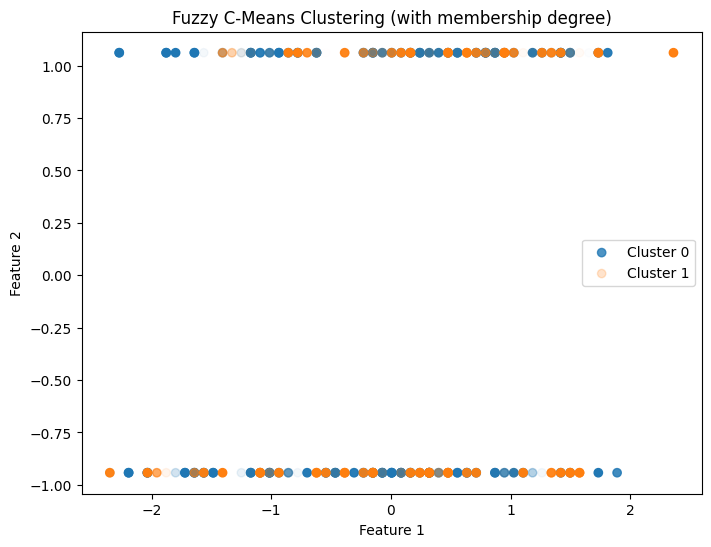

In [ ]:
# Hard clustering from fuzzy membership
cluster_labels = np.argmax(u, axis=0)
print("Fuzzy partition coefficient (FPC):", fpc)

# Plot first two features with fuzzy membership
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],             # Feature 1
        Xexp[cluster_labels == j, 1],             # Feature 2
        alpha=u[j, :],          # transparency ~ membership
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (with membership degree)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

This plot shows the cluster assignments after converting fuzzy memberships into crisp labels. The first two features are displayed, and each sample is colored according to its assigned cluster. This gives a straightforward view of how the fuzzy c-means algorithm separates the data when hard labels are used.


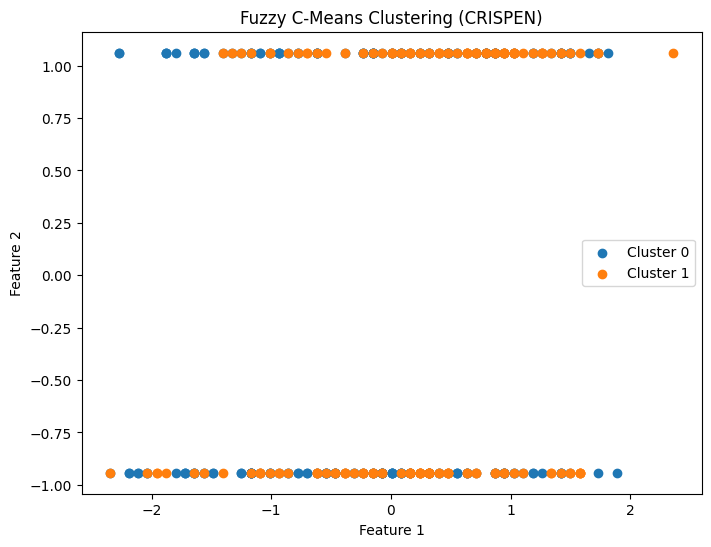

In [ ]:
# Plot first two features with cluster assignments
plt.figure(figsize=(8,6))
for j in range(n_clusters):
    plt.scatter(
        Xexp[cluster_labels == j, 0],
        Xexp[cluster_labels == j, 1],
        label=f'Cluster {j}'
    )

plt.title("Fuzzy C-Means Clustering (CRISPEN)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

This code defines the Gaussian function used for the membership functions in the fuzzy model. A range of values is generated and, for each cluster, the corresponding Gaussian curve is computed using its center and spread for the first feature. The curves are then plotted to show how the membership functions are shaped for that feature.


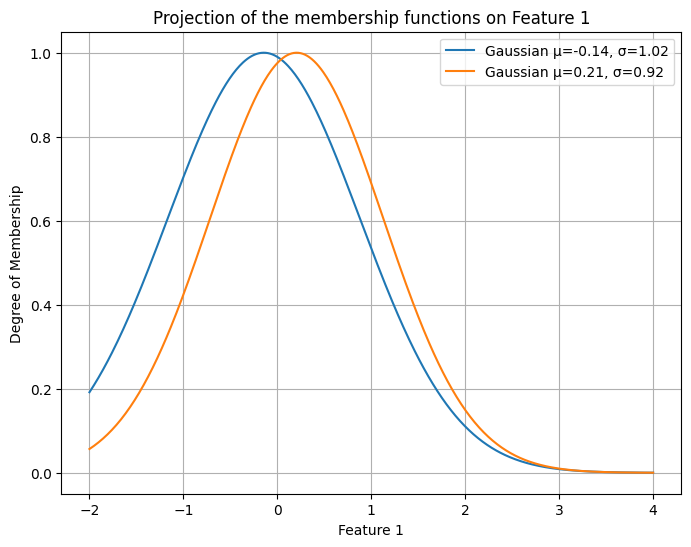

In [ ]:
# Gaussian formula
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu)/sigma)**2)

lin=np.linspace(-2, 4, 500)
plt.figure(figsize=(8,6))

y_aux=[]
for j in range(n_clusters):
# Compute curves
    y_aux.append(gaussian(lin, centers[j,0], sigmas[j,0]))

# Plot
    plt.plot(lin, y_aux[j], label=f"Gaussian μ={np.round(centers[j,0],2)}, σ={np.round(sigmas[j,0],2)}")

plt.title("Projection of the membership functions on Feature 1")
plt.xlabel("Feature 1")
plt.ylabel("Degree of Membership")
plt.legend()
plt.grid(True)
plt.show()

Here the fuzzy inference model is defined. The GaussianMF class creates Gaussian membership functions for each rule and feature, parameterized by centers and spreads obtained from clustering. It computes rule activations by measuring how close each input is to the cluster centers, with an option to choose between probabilistic and max-based aggregation across features. The TSK class implements a Takagi–Sugeno–Kang model: it uses the membership functions to calculate rule firing strengths, normalizes them, and combines the linear outputs of each rule’s consequent into a final prediction.


In [ ]:
# ---------------------------
# Gaussian Membership Function
# ---------------------------
class GaussianMF(nn.Module):
    def __init__(self, centers, sigmas, agg_prob):
        super().__init__()
        self.centers = nn.Parameter(torch.tensor(centers, dtype=torch.float32))
        self.sigmas = nn.Parameter(torch.tensor(sigmas, dtype=torch.float32))
        self.agg_prob=agg_prob

    def forward(self, x):
        # Expand for broadcasting
        # x: (batch, 1, n_dims), centers: (1, n_rules, n_dims), sigmas: (1, n_rules, n_dims)
        diff = abs((x.unsqueeze(1) - self.centers.unsqueeze(0))/self.sigmas.unsqueeze(0)) #(batch, n_rules, n_dims)

        # Aggregation
        if self.agg_prob:
            dist = torch.norm(diff, dim=-1)  # (batch, n_rules) # probablistic intersection
        else:
            dist = torch.max(diff, dim=-1).values  # (batch, n_rules) # min intersection (min instersection of normal funtion is the same as the max on dist)

        return torch.exp(-0.5 * dist ** 2)


# ---------------------------
# TSK Model
# ---------------------------
class TSK(nn.Module):
    def __init__(self, n_inputs, n_rules, centers, sigmas,agg_prob=False):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_rules = n_rules

        # Antecedents (Gaussian MFs)

        self.mfs=GaussianMF(centers, sigmas,agg_prob)

        # Consequents (linear functions of inputs)
        # Each rule has coeffs for each input + bias
        self.consequents = nn.Parameter(
            torch.randn(n_inputs + 1,n_rules)
        )

    def forward(self, x):
        # x: (batch, n_inputs)
        batch_size = x.shape[0]

        # Compute membership values for each input feature
        # firing_strengths: (batch, n_rules)
        firing_strengths = self.mfs(x)

        # Normalize memberships
        # norm_fs: (batch, n_rules)
        norm_fs = firing_strengths / (firing_strengths.sum(dim=1, keepdim=True) + 1e-9)

        # Consequent output (linear model per rule)
        x_aug = torch.cat([x, torch.ones(batch_size, 1)], dim=1)  # add bias

        rule_outputs = torch.einsum("br,rk->bk", x_aug, self.consequents)  # (batch, rules)
        # Weighted sum
        output = torch.sum(norm_fs * rule_outputs, dim=1, keepdim=True)

        return output, norm_fs, rule_outputs



This function trains the consequents of the TSK model using least squares. First, the normalized firing strengths of the rules are
computed. These are combined with the input features (plus a bias term) to build the design matrix Phi (shows how the rules contribute to the output). A least squares solver is then
applied to find the consequent parameters that best fit the training data. The resulting values are reshaped and stored in the model’s
consequent matrix.

In [ ]:
# ---------------------------
# Least Squares Solver for Consequents (TSK)
# ---------------------------
def train_ls(model, X, y):
    with torch.no_grad():
        _, norm_fs, _ = model(X)

        # Design matrix for LS: combine normalized firing strengths with input
        X_aug = torch.cat([X, torch.ones(X.shape[0], 1)], dim=1)

        Phi = torch.einsum("br,bi->bri", X_aug, norm_fs).reshape(X.shape[0], -1)

        # Solve LS: consequents = (Phi^T Phi)^-1 Phi^T y

        theta= torch.linalg.lstsq(Phi, y).solution


        model.consequents.data = theta.reshape(model.consequents.shape)



This function trains the TSK model using gradient descent with the Adam optimizer and Mean Squared Error (MSE) as the loss function. During training, the inputs are passed through the model to generate predictions, which are compared to the true targets to calculate the loss. Backpropagation is then used to compute gradients, and the optimizer updates the model’s parameters to reduce the error. The loss is printed at each epoch to show how the model improves over time.

In [ ]:
# ---------------------------
# Gradient Descent Training
# ---------------------------
def train_gd(model, X, y, epochs=100, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    for _ in range(epochs):
        optimizer.zero_grad()
        y_pred, _, _ = model(X)
        loss = criterion(y_pred, y)
        print(loss)
        loss.backward()
        optimizer.step()

This function performs hybrid training for ANFIS, which combines gradient descent (GD) and least squares (LS). First, it runs LS once to give a starting point for the consequents. Then, for a set number of iterations, the training alternates between two steps: (A) the consequents are frozen and gradient descent is used to update the antecedent parameters (the membership functions), and (B) the antecedents are frozen and the consequents are updated exactly using the least squares solver. At the end of each cycle, the antecedents are re-enabled so the process can continue. This alternating approach makes use of GD for the nonlinear parts and LS for the linear parts.

In [ ]:
# ---------------------------
# Hybrid Training (Classic ANFIS)
# ---------------------------
def train_hybrid_anfis(model, X, y, max_iters=10, gd_epochs=20, lr=1e-3):
    train_ls(model, X, y)
    for _ in range(max_iters):
        # Step A: GD on antecedents (freeze consequents)
        model.consequents.requires_grad = False
        train_gd(model, X, y, epochs=gd_epochs, lr=lr)

        # Step B: LS on consequents (freeze antecedents)
        model.consequents.requires_grad = True
        model.mfs.requires_grad = False
        train_ls(model, X, y)

        # Re-enable antecedents
        model.mfs.requires_grad = True




Here the TSK model is created and prepared for training. The number of inputs is set from the feature dimension and the number of rules
is taken from the number of clusters found in the fuzzy c-means step. Since the clustering was done on the concatenation of features and
target, the last column is removed from the centers and sigmas before passing them to the model so that only feature information is used.
Finally, the training and test sets are converted into PyTorch tensors to be compatible with the model.

In [ ]:
# Build model
model = TSK(n_inputs=Xtr.shape[1], n_rules=n_clusters, centers=centers[:,:-1], sigmas=sigmas[:,:-1])

Xtr = torch.tensor(Xtr, dtype=torch.float32)
ytr = torch.tensor(ytr, dtype=torch.float32)
Xte = torch.tensor(Xte, dtype=torch.float32)
yte = torch.tensor(yte, dtype=torch.float32)


The TSK model is trained using the hybrid ANFIS method. The training inputs (Xtr) and targets (ytr) are passed into train_hybrid_anfis, which alternates between two steps: updating the fuzzy membership functions with gradient descent and updating the linear rule outputs with least squares. In this way, the TSK model learns both the input partitions (antecedents) and the rule consequents directly from the training data.


In [ ]:
# Training with ANFIS:
train_hybrid_anfis(model, Xtr, ytr.reshape(-1,1))


tensor(2683.3926, grad_fn=<MseLossBackward0>)
tensor(2682.0918, grad_fn=<MseLossBackward0>)
tensor(2680.8721, grad_fn=<MseLossBackward0>)
tensor(2679.6763, grad_fn=<MseLossBackward0>)
tensor(2678.5171, grad_fn=<MseLossBackward0>)
tensor(2677.4038, grad_fn=<MseLossBackward0>)
tensor(2676.3215, grad_fn=<MseLossBackward0>)
tensor(2675.2375, grad_fn=<MseLossBackward0>)
tensor(2674.1311, grad_fn=<MseLossBackward0>)
tensor(2673.0347, grad_fn=<MseLossBackward0>)
tensor(2671.9407, grad_fn=<MseLossBackward0>)
tensor(2670.8521, grad_fn=<MseLossBackward0>)
tensor(2669.7756, grad_fn=<MseLossBackward0>)
tensor(2668.6855, grad_fn=<MseLossBackward0>)
tensor(2667.5996, grad_fn=<MseLossBackward0>)
tensor(2666.5107, grad_fn=<MseLossBackward0>)
tensor(2665.4297, grad_fn=<MseLossBackward0>)
tensor(2664.3735, grad_fn=<MseLossBackward0>)
tensor(2663.3264, grad_fn=<MseLossBackward0>)
tensor(2662.2839, grad_fn=<MseLossBackward0>)
tensor(2658.7939, grad_fn=<MseLossBackward0>)
tensor(2657.5190, grad_fn=<MseLoss

The input features Xte are passed through the model to produce predictions (y_pred). These predictions are then compared with the true test targets (yte) using the Mean Squared Error (MSE), which measures how far the predicted values are from the actual values on average. The result is printed as a performance score, with smaller values indicating better accuracy in regression.

In [ ]:
y_pred, _, _=model(Xte)
print(f'ACC:{mean_squared_error(yte.detach().numpy(),y_pred.detach().numpy())}')

ACC:2656.67041015625
